In [ ]:
%pip install numpy

In [ ]:
%pip install pandas

In [ ]:
%pip install networkx

In [ ]:
%pip install matplotlib

In [ ]:
%pip install tqdm

In [296]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from tqdm import tqdm
from networkx.drawing.nx_pydot import graphviz_layout

# Base para todos

In [409]:
def exp_mechanism_geral(data, score_func, list_outputs, epsilon, global_sensivity, target = None):
    scores = [score_func(data, out, target) if target != None else score_func(data, out) for out in list_outputs]
    probs = [np.exp(epsilon * score / (2 * global_sensivity)) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)

    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]

def dampening_function(data, output, score_func, delta_func, target = None):
    def b_func(data, i, output):
        if i == 0:
            return 0
        return sum([delta_func(data, j, output, target) if target != None else delta_func(data, j, output) for j in range(i - 1)])
    
    i = 0  
    score = score_func(data, output, target) if target != None else score_func(data, output)
    while True:
        b_i = b_func(data, i, output)
        b_ipp = b_func(data, i + 1, output)
        if (score > 0 and (score < b_i or score >= b_ipp)) or (score < 0 and (score < -b_ipp or score >= -b_i)):
            i += 1
            continue

        return (score - b_i) / (b_ipp - b_i) + i if score > 0 else (score + b_i) / (-b_ipp + b_i) - i

def local_dampening_mechanism(data, score_func, delta_func, list_outputs, epsilon, target = None):
    scores = [dampening_function(data, out, score_func, delta_func, target) if target != None else dampening_function(data, out, score_func, delta_func) for out in list_outputs]
    probs = [np.exp(epsilon * score / 2) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)
    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]



def permute_and_flip(data, score_func, list_outputs, epsilon, global_sensivity):
    max_score = max([score_func(data, out) for out in list_outputs])
    # aqui talvez seja interessante copiar e passar a copia da list_ouputs
    np.random.shuffle(list_outputs)
    for r in list_outputs:
        prob = np.exp(epsilon * (score_func(data, r) - max_score) / (2 * global_sensivity))
        if np.random.rand() < prob:
            return r


# Algoritmo 7

In [5]:
data = {
 "Outlook": ["rain", "rain", "sun", "sun", "sun"], 
 "Wind": ["strong", "weak", "strong", "weak", "strong"], 
 "Decision":  ["Y", "N", "Y", "N", "N"]
}

df = pd.DataFrame(data)
df

,Outlook,Wind,Decision
0,rain,strong,Y
1,rain,weak,N
2,sun,strong,Y
3,sun,weak,N
4,sun,strong,N


In [429]:
def get_canditates(data, t, value_column, target, coluna, label):
    # se a distancia for 0
    if t == 0:
      # dataframe onde o atributo A possui valor j
      ## no caso, a coluna possui value_column
      qtd_T_value_columnA = data[data[coluna] == value_column]
      # dataframe onde o atributo A possui valor j e alvo é c de C
      ## no caso, a coluna possui value_column e o label é oque procuramos
      value_columnA_target = qtd_T_value_columnA[qtd_T_value_columnA[label] == target]

      return qtd_T_value_columnA.shape[0], value_columnA_target.shape[0]
    candidates = get_canditates(data, t-1, value_column, target, coluna, label)
    validos_candidates = []

    print(candidates)
    if isinstance(candidates, tuple):
      x, y = candidates
      if x > 0 and y > 0:
          validos_candidates.append((x - 1, y - 1))
      if x < data.shape[0]:
        validos_candidates.append((x + 1, y))
    else:
      for x, y in candidates:
        if x > 0 and y > 0:
          validos_candidates.append((x - 1, y - 1))
        if x < data.shape[0]:
          validos_candidates.append((x + 1, y))
    return validos_candidates

def h_func(x, y):
    def f_func(x, somar = False):
        return x * np.log2((x + 1) / x) + np.log2(x + 1) if somar else x * np.log2((x - 1) / x) - np.log2(x - 1)
    return max(f_func(x, True) - f_func(y, True), f_func(x) - f_func(y))

def local_sensivity_at_tDistance_alg7(data:pd.DataFrame, t:float, col_val, target):
    '''
    data = dataframe

    t = distâncuia

    col_val = uma coluna do dataframe

    target_values = lista com todas saídas possíveis do label
    '''
    H = []
    for a in data[col_val].unique():
      # iterar sobre as classes daquela coluna
      for c in data[target].unique():
        # ver os candidatos
        candidates = get_canditates(data, t, a, c, col_val, target)
        # para cada candidato, calcular a h_func e add a H
        # print(type(candidates))
        if isinstance(candidates, tuple):
           H.append(h_func(candidates[0], candidates[1]))
        else:
          print("DOITOOODASKDOAK")
          for x, y in candidates:
            H.append(h_func(x,y))
    # retoanr o maior valor H (entropy)
    return max(H)

In [430]:
def noisy_count(data: pd.DataFrame, target, epsilon):
    '''
    Calcula uma estimativa ruidosa da contagem da coluna alvo (target) do dataframe usando o mecanismo NoisyCount.
    
    Parâmetros:
        data (pd.DataFrame): O dataframe contendo os dados.
        target (str): O nome da coluna alvo.
        epsilon (float): O parâmetro de privacidade epsilon para o mecanismo NoisyCount.
    
    Retorna:
        float: A contagem ruidosa da coluna alvo.
    '''
    # Contagem exata da coluna alvo
    exact_count = data[target].count()
    
    noise = np.random.laplace(scale=1/epsilon)
    
    # Adicionar o ruído ao contador exato
    noisy_count = exact_count + noise
    
    return noisy_count

# Equação 7.2
def score_func_exp(data: pd.DataFrame, r, target):
    '''
    r = uma coluna específica do dataframe
    '''
    infGain_list = []
    for c in data[target].unique():
      for a in data[r].unique():
        data_colR_valA = data[data[r] == a]
        data_colR_valA_outC = data_colR_valA[data_colR_valA[target] == c]
        tau_jc = data_colR_valA_outC.shape[0]
        tau_j = data_colR_valA.shape[0]
        if tau_jc == 0 or tau_j == 0:
            infGain_list.append(0.)
            continue 
        infGain_list.append(tau_jc * np.log2(tau_jc / tau_j))

    # print(infGain_list)
    return -sum(infGain_list)

def build_diff_PID3(data:pd.DataFrame, list_columns: list, target, profundidade, epsilon):
    data_target_list = data[target].unique()
    if len(list_columns) == 0 or profundidade == 0:
        data_output_partitions = [noisy_count(data[data[target] == c], target, epsilon) for c in data_target_list]
        max_Nc = max(data_output_partitions)
        return (data_target_list[data_output_partitions.index(max_Nc)]) 
    t_val = max([len(data[col].unique()) for col in list_columns])
    N_t = noisy_count(data, target, epsilon)
    if N_t / (t_val * len(data_target_list)) < np.sqrt(2)/2:
        data_output_partitions = [noisy_count(data[data[target] == c], target, epsilon) for c in data_target_list]
        max_Nc = max(data_output_partitions)
        return (data_target_list[data_output_partitions.index(max_Nc)]) 
        
    # columns_hat = exp_mechanism_geral(data, score_func_exp, list_columns, epsilon, np.log2(data.shape[0] + 1) + 1/np.log(2), target)
    # local_sensivity_at_tDistance_alg7
    columns_hat = local_dampening_mechanism(data, score_func_exp, local_sensivity_at_tDistance_alg7, list_columns, epsilon, target)
    data_i = [(data[data[columns_hat] == i], i ) for i in data[columns_hat].unique()]
    list_columns.remove(columns_hat)
    arvore = []
    for dado in data_i:
        root_node = build_diff_PID3(dado[0], list_columns, target, profundidade - 1, epsilon)
        arvore.append({
            "from": columns_hat,
            "to": root_node,
            "edge_name": dado[1]
        })
    
    return arvore

def global_diff_PID3(data:pd.DataFrame, target, profundidade: int, privacy_budget: float):
    '''
    data = um dataframe
    target = a coluna alvo, no exemplo do tempo, seria o Y e o N
    profundidade = numero que indica a profuntidade
    privacy_budget = nivel de privacidade numero
    '''
    epsilon = privacy_budget / (2 * (profundidade + 1))
    lista_colunas = data.columns.to_list()
    lista_colunas.remove(target)
    return build_diff_PID3(data, lista_colunas, target, profundidade, epsilon)

# Atribua um valor de privacidade para o orçamento de privacidade
epsilon = 10

# Chame a função global_diff_PID3 para construir a árvore de decisão diferencial com privacidade global
arvore_molde = global_diff_PID3(df, "Decision", 2, epsilon)

(2, 1)
DOITOOODASKDOAK


C:\Users\b47133\AppData\Local\Temp\ipykernel_12044\3488727077.py:32: RuntimeWarning: divide by zero encountered in log2
  return x * np.log2((x + 1) / x) + np.log2(x + 1) if somar else x * np.log2((x - 1) / x) - np.log2(x - 1)
C:\Users\b47133\AppData\Local\Temp\ipykernel_12044\3488727077.py:32: RuntimeWarning: invalid value encountered in scalar subtract
  return x * np.log2((x + 1) / x) + np.log2(x + 1) if somar else x * np.log2((x - 1) / x) - np.log2(x - 1)


ZeroDivisionError: division by zero

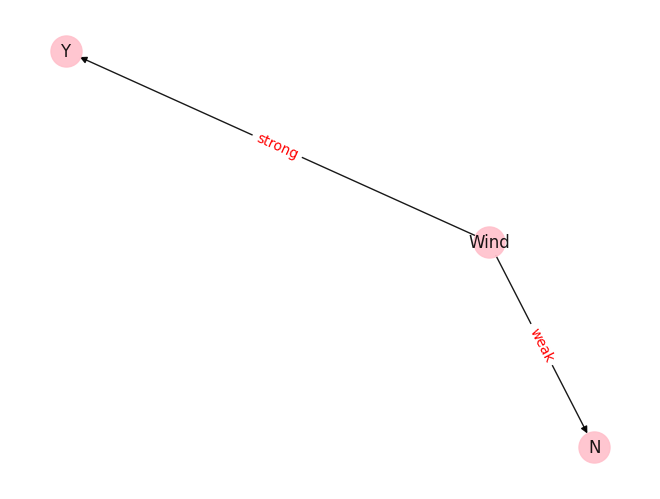

In [401]:
# nx.draw(arvore)
# plt.show()
def molde2draw(molde):
    G = nx.DiGraph()
    edge_labels = {}
    for dict_node in molde:
        to_node = dict_node["to"]
        G.add_edge(dict_node["from"], dict_node["to"])
        edge_labels[(dict_node["from"], dict_node["to"])] = dict_node["edge_name"]
    pos = nx.spring_layout(G)
    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='pink', alpha=0.9,
        labels={node: node for node in G.nodes()}
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_color='red'
    )
    plt.axis('off')
    plt.show()
# print(arvore_molde)
molde2draw(arvore_molde)

# Algoritmo 5

saida: o indíce do valor mais próximo da mediana

entrada: vetor x, com todos valores entre 0 e $\Lambda$

In [139]:
def local_sensivity_at_0(x:list, idx:int):
    m = int(np.ceil(len(x)/2))
    def p(x, i):
        if i > m:
            return max(x) - x[i]
        if i == m:
            return max(x) - x[m + 1]
        return max(x) + x[i] - 3 * x[m] + x[m + 1]
    def q(x,i):
        if i > m:
            return x[i]
        if i == m:
            return x[m - 1]
        return 3 * x[m] - x[m - 1] - x[i]
    return max(
        np.abs(x[m] - x[idx]), 
        x[m + 1] - x[m],
        x[m] - x[m - 1],
        p(x,idx),
        q(x,idx)
    )
    
def get_canditates_alg5(x, t, i):
    m = int(np.ceil(len(x)/2))
    if t == 0:
        return [x]
    if t == 1:
        list_candidates = [x.copy() for j in range(6)]
        list_candidates[0][-1] = x[i]
        list_candidates[1] = list_candidates[0]
        list_candidates[2][0] = x[i]
        list_candidates[3] = list_candidates[2]
        list_candidates[4][-1] = x[m]
        list_candidates[5][0] = x[m]
        return list_candidates
    list_candidates = get_canditates_alg5(x, t-1, i)
    # print(list_candidates)
    list_candidates[0][0] = list_candidates[0][m]
    list_candidates[1][-1] = list_candidates[1][m]
    list_candidates[2][0] = list_candidates[2][m]
    list_candidates[3][-1] = list_candidates[3][m]
    list_candidates[4][0] = list_candidates[4][m]
    list_candidates[5][-1] = list_candidates[5][m]
    return list_candidates

def local_sensivity_at_tDistance(x, t, i):
    list_candidates = get_canditates_alg5(x, t, i)
    return max(local_sensivity_at_0(candidate, i) for candidate in list_candidates)

def score_func(x, idx):
    m = int(np.ceil(len(x)/2))
    return -np.abs(x[m] - x[idx])

In [156]:
x = [1,3,4,5,10,32,34,37,200]
epsilon = 100
# delta u
max_u = max(x)
n_amostras = 10000
list_outputs = [i for i in range(len(x))]
# delta star
max_utility = max(score_func(x, i) for i in range(len(x)))

## Avalaiando

In [184]:
def avaliation(x, score_func, list_outputs, epsilon_range, max_u = None, n_amostras = 10000, typo_mech = "exp"):
    evaluate = {}
    for epsilon in tqdm(epsilon_range, desc="Processando epsilons", unit=" valor"):
        if typo_mech == "exp":
            evaluate[epsilon] = [exp_mechanism_geral(x, score_func, list_outputs, epsilon, max_u) for i in range(n_amostras)]
        if typo_mech == "paf":
            evaluate[epsilon] = [permute_and_flip(x, score_func, list_outputs, epsilon, max_u) for i in range(n_amostras)]
    
    return evaluate

epsilons = np.linspace(10**-3, 10**3, 100)

### exponencial mechanism

In [185]:
evalueate_exp = avaliation(x, score_func, list_outputs, epsilons, max_u, typo_mech = "exp")

Processando epsilons: 100%|██████████| 100/100 [01:44<00:00,  1.05s/ valor]


In [ ]:
for ep, err in evalueate_exp.items():
    print(err)

### permuta and flip

In [186]:
evalueate_paf = avaliation(x, score_func, list_outputs, epsilons, max_u, typo_mech = "paf")

Processando epsilons: 100%|██████████| 100/100 [00:47<00:00,  2.12 valor/s]


In [ ]:
for ep, err in evalueate_paf.items():
    print(err)

### Local Dampening

In [187]:
experimentations = [local_dampening_mechanism(x, score_func, local_sensivity_at_tDistance, [i for i in range(len(x))], epsilon) for i in range(n_amostras)]
dict_stats = {}
for i in experimentations:
    if x[i] in dict_stats:
        dict_stats[x[i]] += 1
    else:
        dict_stats[x[i]] = 1
dict_stats_sorted = dict(sorted(dict_stats.items(), key=lambda item: item[1], reverse=True))
for k,v in dict_stats_sorted.items():
    print(f"o valor {k} foi retornado {v} vezes")

print(f"\nTaxa de epsilon = {epsilon}\nMediana real = {x[int(np.ceil(len(x)/2))]}\nNúmero de amostras = {n_amostras}\n\nX verdadeiro: {x}")

[1.343160901102686e-17, 5.641892828832433e-18, 3.690221943266237e-18, 2.42805643042292e-18, 3.2594197844862084e-19, nan, 3.5228900314972523e-22, 8.940704392217478e-22, 0.00033546262790251126]
[nan nan nan nan nan nan nan nan nan]


C:\Users\b47133\AppData\Local\Temp\ipykernel_12044\2203152617.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return (score - b_i) / (b_ipp - b_i) + i if score > 0 else (score + b_i) / (-b_ipp + b_i) - i


ValueError: probabilities contain NaN